In [27]:
import pandas as pd
import numpy as np

Зчитаємо файл `diabetes.csv`

In [88]:
diabetes_df = pd.read_csv('diabetes.csv')

In [89]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [90]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Вихідна величина - `Outcome`, а вхідні величини - `Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age`

In [31]:
for col in diabetes_df.columns:
    num_zeros = (diabetes_df[col] == 0).sum()
    print(f"{col}: {num_zeros} zero values")

Pregnancies: 111 zero values
Glucose: 5 zero values
BloodPressure: 35 zero values
SkinThickness: 227 zero values
Insulin: 374 zero values
BMI: 11 zero values
DiabetesPedigreeFunction: 0 zero values
Age: 0 zero values
Outcome: 500 zero values


Значення `Glucose, BloodPressure, SkinThickness, Insulin, BMI` містять нульові значення, але насправді це неможливо, тому це є індикатором пропущених значень.  
Напишемо функцію, яка буде замінювати нульові значення цих атрибутів залежно від того, чи людина має цукровий діабет.

In [32]:
def fill_missing_values(df):

    # Замінюємо "неможливі" нулі на NaN
    cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    df[cols] = df[cols].replace(0, np.nan)
    
    outcome_groups = df.groupby('Outcome')
    median_by_outcome = outcome_groups.median()
    
    for col in cols:
        for outcome in [0, 1]:
            df.loc[(df[col].isnull()) & (df['Outcome'] == outcome), col] = median_by_outcome.loc[outcome, col]
            
    return df

In [33]:
diabetes_df = fill_missing_values(diabetes_df)

In [34]:
for col in diabetes_df.columns:
    num_zeros = (diabetes_df[col] == 0).sum()
    print(f"{col}: {num_zeros} zero values")

Pregnancies: 111 zero values
Glucose: 0 zero values
BloodPressure: 0 zero values
SkinThickness: 0 zero values
Insulin: 0 zero values
BMI: 0 zero values
DiabetesPedigreeFunction: 0 zero values
Age: 0 zero values
Outcome: 500 zero values


Отже, тепер нерелевантні нулі видалено.

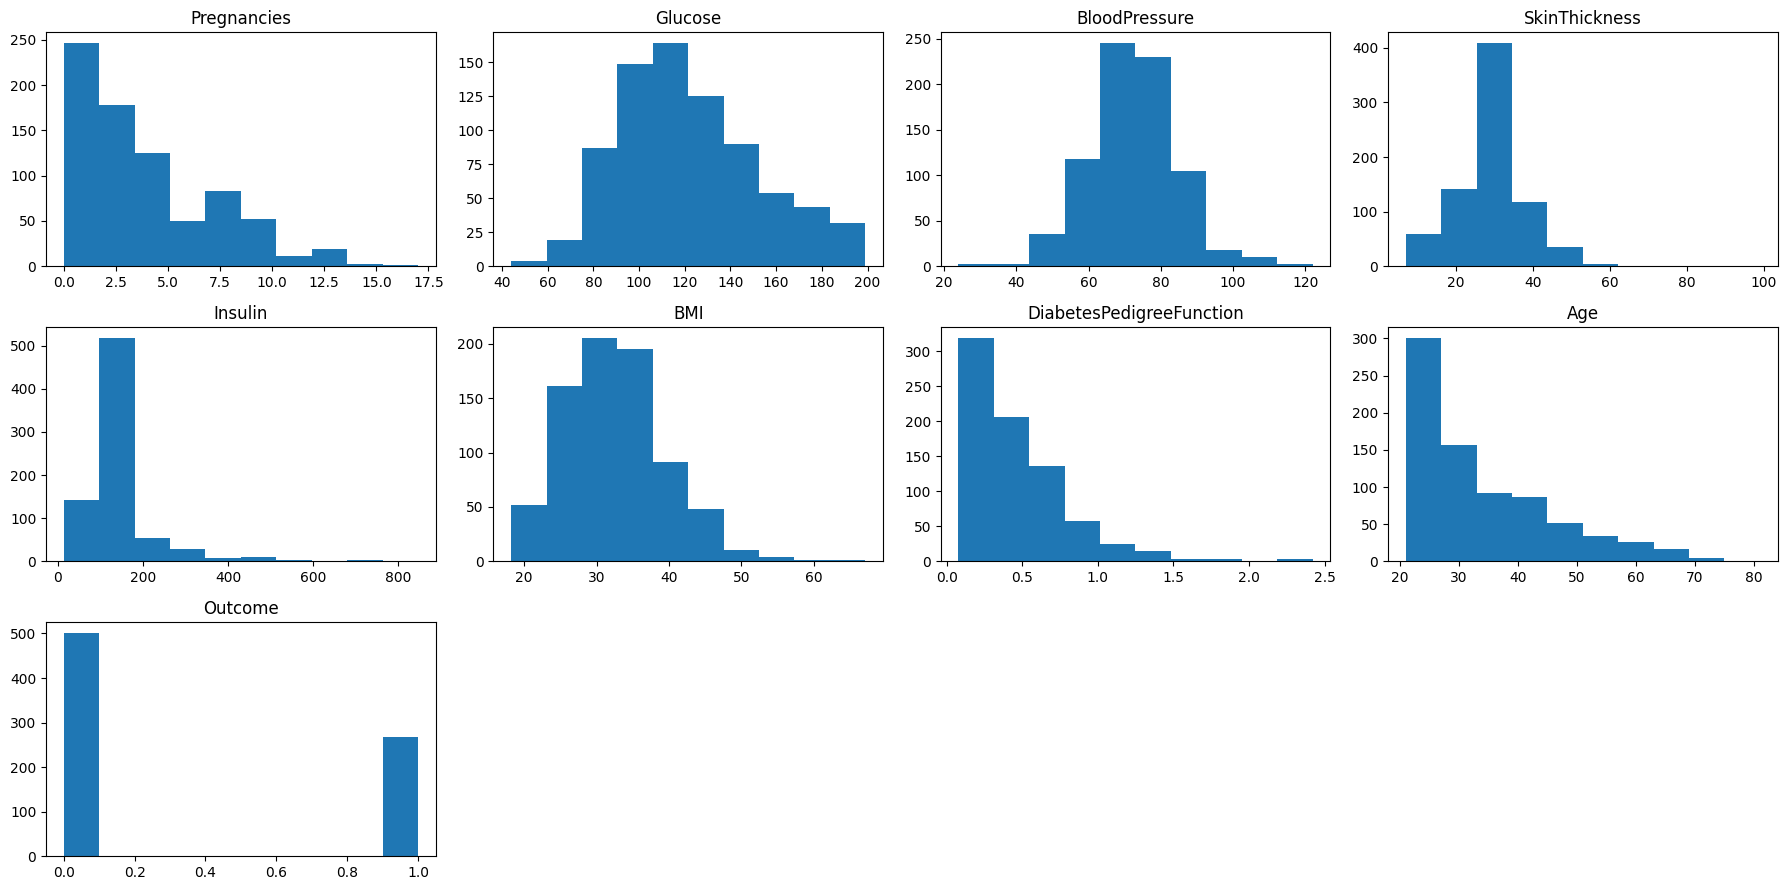

In [35]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18, 9))

for i in range(9):
    plt.subplot(3, 4, i + 1)
    plt.hist(diabetes_df.iloc[:,i])
    plt.title(diabetes_df.columns[i])
    
plt.tight_layout()     
plt.show()

In [91]:
X, y = diabetes_df.loc[:, diabetes_df.columns != 'Outcome'], diabetes_df['Outcome'].values

Створимо словник, у якому будемо зберігати результати наших моделей.

In [37]:
model_results = {}

In [38]:
from sklearn.model_selection import KFold

kf = KFold(
    n_splits=4,
    shuffle=True,
    random_state=42
)

<b>1) Логістична регресія</b>

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

precision_scores, recall_scores, f1_scores, aucs = [], [], [], []

for train_idx, test_idx in kf.split(X, y):
    X_train, y_train = X.loc[train_idx], y[train_idx]
    X_test, y_test = X.loc[test_idx], y[test_idx]
    
    model = LogisticRegression(max_iter=1000, random_state=42).fit(X_train, y_train)
    y_test_probs = model.predict_proba(X_test)[:, 1]
    y_test_preds = model.predict(X_test)

    precision_scores.append(precision_score(y_test, y_test_preds))
    recall_scores.append(recall_score(y_test, y_test_preds))
    f1_scores.append(f1_score(y_test, y_test_preds))
    aucs.append(roc_auc_score(y_test, y_test_preds))

print(f'Precision: {np.mean(precision_scores):.4f} +- {np.std(precision_scores):.4f}')
print(f'Recall: {np.mean(recall_scores):.4f} +- {np.std(recall_scores):.4f}')
print(f'F1 score: {np.mean(f1_scores):.4f} +- {np.std(f1_scores):.4f}')
print(f'AUC: {np.mean(aucs):.4f} +- {np.std(aucs):.4f}')

Precision: 0.6870 +- 0.0335
Recall: 0.5842 +- 0.0567
F1 score: 0.6291 +- 0.0312
AUC: 0.7201 +- 0.0255


У випадку, якщо модель передбачить у пацієнта діабет, то пацієнту будуть призначені додаткові дослідження. Тому у нашому випадку false positives краще, ніж false negatives. Метрика Recall, на якій потрібно більше сконцентруватися, вийшла низька

За замовчуванням у нашого класифікатора порогове значення 0.5, тому спробуємо знизити цей поріг:

In [40]:
results = []
for thr in np.linspace(0.05, 0.5, 10):
    precision_scores, recall_scores, f1_scores, aucs = [], [], [], []
    for train_idx, test_idx in kf.split(X, y):
        X_train, y_train = X.loc[train_idx], y[train_idx]
        X_test, y_test = X.loc[test_idx], y[test_idx]

        model = LogisticRegression(max_iter=1000, random_state=42).fit(X_train, y_train)

        y_test_preds = model.predict(X_test)

        y_test_probs = model.predict_proba(X_test)[:, 1]
        y_test_preds = (y_test_probs >= thr).astype(int)

        precision_scores.append(precision_score(y_test, y_test_preds))
        recall_scores.append(recall_score(y_test, y_test_preds))
        f1_scores.append(f1_score(y_test, y_test_preds))
        aucs.append(roc_auc_score(y_test, y_test_preds))
    # Treshold / Precision / Recall / F1 score / AUC
    results.append([thr, 
                    f'{np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}',
                   f'{np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}',
                   f'{np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}',
                   f'{np.mean(aucs):.4f} +- {np.std(aucs):.4f}'])

In [41]:
pd.DataFrame(results, columns=['Threshold', 'Precision', 'Recall', 'F1 score', 'AUC'])

,Threshold,Precision,Recall,F1 score,AUC
0,0.05,0.3958 ± 0.0267,0.9928 ± 0.0072,0.5654 ± 0.0272,0.5898 +- 0.0150
1,0.10,0.4629 ± 0.0179,0.9783 ± 0.0299,0.6281 ± 0.0171,0.6850 +- 0.0190
2,0.15,0.5103 ± 0.0256,0.9597 ± 0.0342,0.6658 ± 0.0237,0.7328 +- 0.0259
3,0.20,0.5598 ± 0.0192,0.9044 ± 0.0372,0.6910 ± 0.0168,0.7609 +- 0.0288
4,0.25,0.6042 ± 0.0328,0.8636 ± 0.0559,0.7098 ± 0.0316,0.7783 +- 0.0393
5,0.30,0.6407 ± 0.0392,0.8264 ± 0.0473,0.7202 ± 0.0276,0.7868 +- 0.0335
6,0.35,0.6699 ± 0.0437,0.7525 ± 0.0553,0.7069 ± 0.0333,0.7750 +- 0.0356
7,0.40,0.6691 ± 0.0391,0.6695 ± 0.0363,0.6679 ± 0.0224,0.7445 +- 0.0245
8,0.45,0.6767 ± 0.0349,0.6255 ± 0.0626,0.6474 ± 0.0320,0.7317 +- 0.0282
9,0.50,0.6870 ± 0.0335,0.5842 ± 0.0567,0.6291 ± 0.0312,0.7201 +- 0.0255


Якщо відштовхуватися від F1 score, то оптимальним буде `threshold = 0.3`.

In [42]:
model_results['LR with thr=0.3'] = {'Precision': np.mean(precision_scores),
                                  'Recall': np.mean(recall_scores),
                                  'F1 score': np.mean(f1_scores),
                                  'AUC': np.mean(aucs)
                                  }

<b>2) SVM</b>

In [43]:
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import GridSearchCV

In [44]:
svm = SVC()

# ініціалізуємо список параметрів, які будемо перебирати
params_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.5, 1, 2, 5]
}

# шукаємо оптимальні значення параметрів
clf = GridSearchCV(
    estimator=svm,
    param_grid=params_grid,
    scoring='f1',
    cv=4
)

clf = clf.fit(X, y)
grid_search_results = pd.DataFrame(clf.cv_results_)

grid_search_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,1.363369,0.113158,0.006156,0.000886,0.5,linear,"{'C': 0.5, 'kernel': 'linear'}",0.645161,0.629921,0.661017,0.708661,0.661190,0.029531,11
1,0.020659,0.003298,0.007249,0.001921,0.5,poly,"{'C': 0.5, 'kernel': 'poly'}",0.774194,0.722689,0.700855,0.750000,0.736934,0.027675,8
2,0.012360,0.004655,0.012523,0.002100,0.5,rbf,"{'C': 0.5, 'kernel': 'rbf'}",0.794118,0.758621,0.820144,0.746667,0.779887,0.029064,6
3,0.025457,0.002440,0.012104,0.001102,0.5,sigmoid,"{'C': 0.5, 'kernel': 'sigmoid'}",0.050847,0.035714,0.016667,0.019231,0.030615,0.013780,15
4,2.930663,0.513752,0.005762,0.001283,1,linear,"{'C': 1, 'kernel': 'linear'}",0.650407,0.629921,0.661017,0.714286,0.663908,0.031160,9
5,0.028050,0.011773,0.006792,0.003130,1,poly,"{'C': 1, 'kernel': 'poly'}",0.786885,0.737705,0.774194,0.757143,0.763982,0.018480,7
6,0.010791,0.003752,0.011464,0.003868,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.814815,0.769231,0.820144,0.751678,0.788967,0.029241,4
7,0.028137,0.003849,0.010996,0.001794,1,sigmoid,"{'C': 1, 'kernel': 'sigmoid'}",0.046512,0.031746,0.015152,0.017699,0.027777,0.012527,16
8,5.914156,1.047449,0.007543,0.000524,2,linear,"{'C': 2, 'kernel': 'linear'}",0.645161,0.608000,0.666667,0.720000,0.659957,0.040524,12
9,0.034402,0.004818,0.007631,0.000847,2,poly,"{'C': 2, 'kernel': 'poly'}",0.790323,0.761905,0.800000,0.785714,0.784485,0.014019,5


Параметри `{'C': 5, 'kernel': 'rbf'}` дали найкращий результат `f1_score = 0.799894	+- 0.029344`. Але спробуємо ще декілька інших паметрів. Також помітимо, що значення kernel linear та sigmoid дали найгірші результати, тому приберемо їх з параметрів, щоб пришвидшити час пошуку. 

In [45]:
svm = SVC()

# ініціалізуємо список параметрів, які будемо перебирати
params_grid = {
    'kernel': ['poly', 'rbf'],
    'C': [7, 10, 20]
}

# шукаємо оптимальні значення параметрів
clf = GridSearchCV(
    estimator=svm,
    param_grid=params_grid,
    scoring='f1',
    cv=4
)

clf = clf.fit(X, y)
grid_search_results = pd.DataFrame(clf.cv_results_)

grid_search_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.061037,0.009354,0.007817,0.000482,7,poly,"{'C': 7, 'kernel': 'poly'}",0.816000,0.740157,0.821705,0.785185,0.790762,0.032351,5
1,0.016754,0.000790,0.013676,0.001347,7,rbf,"{'C': 7, 'kernel': 'rbf'}",0.818182,0.788321,0.836879,0.761905,0.801322,0.028598,2
2,0.079160,0.016262,0.008129,0.002937,10,poly,"{'C': 10, 'kernel': 'poly'}",0.828125,0.730159,0.821705,0.785185,0.791294,0.038911,4
3,0.017491,0.000894,0.012247,0.000394,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.824427,0.788321,0.836879,0.761905,0.802883,0.029628,1
4,0.111203,0.010598,0.007238,0.000831,20,poly,"{'C': 20, 'kernel': 'poly'}",0.834646,0.730159,0.821705,0.761194,0.786926,0.042929,6
5,0.017492,0.000875,0.012935,0.000624,20,rbf,"{'C': 20, 'kernel': 'rbf'}",0.824427,0.763359,0.838235,0.770270,0.799073,0.032717,3


Отже, `{'C': 10, 'kernel': 'rbf'}` виявилися найкращими за результатами GridSearchCV, `f1_score = 0.802883 +- 0.029628`

Оберемо ці параметри і проведемо крос-валідацію для оцінки нашої моделі:

In [46]:
def cv_svc(X, y):
    precisions, recalls, f1s, aucs = [], [], [], []
    for train_idx, test_idx in kf.split(X):
        X_train, y_train = X.loc[train_idx], y[train_idx]
        X_test, y_test = X.loc[test_idx], y[test_idx]
        
        svc = SVC(kernel='rbf', C=10, random_state=42).fit(X_train, y_train)
        
        y_pred = svc.predict(X_test)
        
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        aucs.append(roc_auc_score(y_test, y_pred))
        
    avg_precision = sum(precisions)/kf.n_splits
    avg_recall = sum(recalls)/kf.n_splits
    avg_f1 = sum(f1s)/kf.n_splits
    avg_auc = sum(aucs)/kf.n_splits
        
    return [avg_precision, avg_recall, avg_f1, avg_auc]

In [47]:
results = cv_svc(X, y)

print(f'Average Precision: {results[0]}')
print(f'Average Recall: {results[1]}')
print(f'Average F1-score: {results[2]}')
print(f'Average AUC: {results[3]}')

Average Precision: 0.7869756640713501
Average Recall: 0.8430743644571157
Average F1-score: 0.8140124070471781
Average AUC: 0.8605382993389656


In [48]:
model_results['SVC'] = {'Precision': results[0],
                                  'Recall': results[1],
                                  'F1 score': results[2],
                                  'AUC': results[3]
                                  }

<b>3) KMeans</b>

In [49]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report

km = KMeans(
    n_clusters=2,
    n_init=10,
    random_state=42
)

km = km.fit(X)
y_pred = km.predict(X)

class_report = classification_report(y, y_pred)

In [50]:
print(class_report)

              precision    recall  f1-score   support

           0       0.66      0.95      0.78       500
           1       0.52      0.11      0.18       268

    accuracy                           0.65       768
   macro avg       0.59      0.53      0.48       768
weighted avg       0.61      0.65      0.57       768



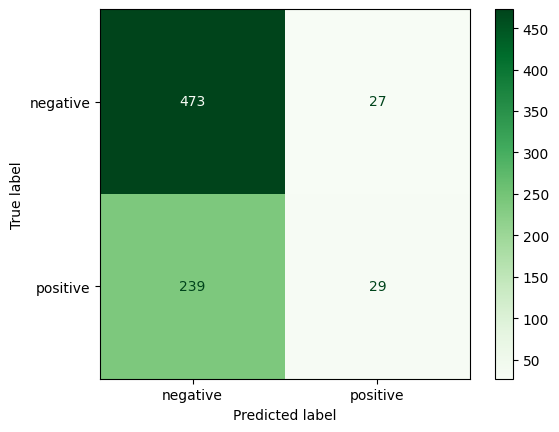

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y, y_pred)

labels = ['negative', 'positive']
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cm_display.plot(cmap=plt.cm.Greens)

In [52]:
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')

Precision: 0.5178571428571429
Recall: 0.10820895522388059
F1-score: 0.17901234567901234


Бачимо, що результат вийшов не дуже змістовним. Особливо у сенсі хибнонегативниї помилок.  
Можливо, справа в тому, що колонка "Insulin" мала багато нерелавантних нулів, які були замінені медіанними значеннями для кожної групи. Тому спробуємо видалити цю колонку.

In [53]:
X_kmeans = X.drop(["Insulin"], axis=1, inplace=False)

In [54]:
km = KMeans(
    n_clusters=2,
    n_init=10,
    random_state=42
)

km = km.fit(X_kmeans)
y_pred = km.predict(X_kmeans)

class_report = classification_report(y, y_pred)

In [55]:
print(class_report)

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       500
           1       0.64      0.63      0.64       268

    accuracy                           0.75       768
   macro avg       0.72      0.72      0.72       768
weighted avg       0.75      0.75      0.75       768



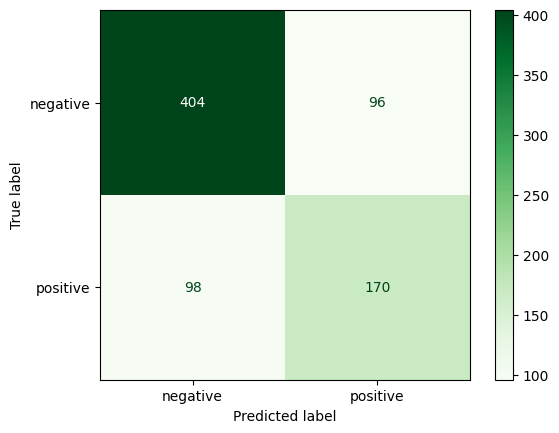

In [56]:
cm = confusion_matrix(y, y_pred)

labels = ['negative', 'positive']
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cm_display.plot(cmap=plt.cm.Greens)

In [57]:
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_pred)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(f'AUC: {auc}')

Precision: 0.6390977443609023
Recall: 0.6343283582089553
F1-score: 0.6367041198501873
AUC: 0.7211641791044777


In [62]:
model_results['KMeans'] = {'Precision': precision,
                        'Recall': recall,
                        'F1 score': f1,
                        'AUC': auc
                        }

Справді, отримано вже кращі результати. Була зменшена кількість хибнонегативних помилок, які у нашому дослідженні "гірші" за хибнопозитивні помилки.

<b>4) NBC</b>

In [63]:
from sklearn.naive_bayes import GaussianNB

def cv_nbc(X, y):
    precisions, recalls, f1s, aucs = [], [], [], []
    for train_idx, test_idx in kf.split(X):
        X_train, y_train = X.loc[train_idx], y[train_idx]
        X_test, y_test = X.loc[test_idx], y[test_idx]
        
        nbc = GaussianNB().fit(X_train, y_train)
        y_pred = nbc.predict(X_test)
        
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        aucs.append(roc_auc_score(y_test, y_pred))
        
    avg_precision = sum(precisions)/kf.n_splits
    avg_recall = sum(recalls)/kf.n_splits
    avg_f1 = sum(f1s)/kf.n_splits
    avg_auc = sum(aucs)/kf.n_splits
        
    return [avg_precision, avg_recall, avg_f1, avg_auc]


In [64]:
results = cv_nbc(X, y)

print(f'Average Precision: {results[0]}')
print(f'Average Recall: {results[1]}')
print(f'Average F1-score: {results[2]}')
print(f'Average AUC: {results[3]}')

Average Precision: 0.6687646370023419
Average Recall: 0.6291280589213589
Average F1-score: 0.6465076641500801
Average AUC: 0.7304394095885266


In [65]:
model_results['NBC'] = {'Precision': results[0],
                        'Recall': results[1],
                        'F1 score': results[2],
                        'AUC': results[3]
                        }

<b>5) Decision Tree</b>

In [66]:
from sklearn.tree import DecisionTreeClassifier

def cv_tree(X, y, max_depth=10):
    precisions, recalls, f1s, aucs = [], [], [], []
    for train_idx, test_idx in kf.split(X):
        X_train, y_train = X.loc[train_idx], y[train_idx]
        X_test, y_test = X.loc[test_idx], y[test_idx]
        
        tree = DecisionTreeClassifier(max_depth=max_depth, random_state=42).fit(X_train, y_train)
        y_pred = tree.predict(X_test)
        
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        aucs.append(roc_auc_score(y_test, y_pred))
        
    avg_precision = sum(precisions)/kf.n_splits
    avg_recall = sum(recalls)/kf.n_splits
    avg_f1 = sum(f1s)/kf.n_splits
    avg_auc = sum(aucs)/kf.n_splits
        
    return [avg_precision, avg_recall, avg_f1, avg_auc]

In [67]:
results = cv_tree(X, y, max_depth=12)

print(f'Average Precision: {results[0]}')
print(f'Average Recall: {results[1]}')
print(f'Average F1-score: {results[2]}')
print(f'Average AUC: {results[3]}')

Average Precision: 0.7837322217775682
Average Recall: 0.7877761938702779
Average F1-score: 0.7849127486718447
Average AUC: 0.835689747776075


In [68]:
model_results['DecisionTreeClassifier'] = {'Precision': results[0],
                        'Recall': results[1],
                        'F1 score': results[2],
                        'AUC': results[3]
                        }

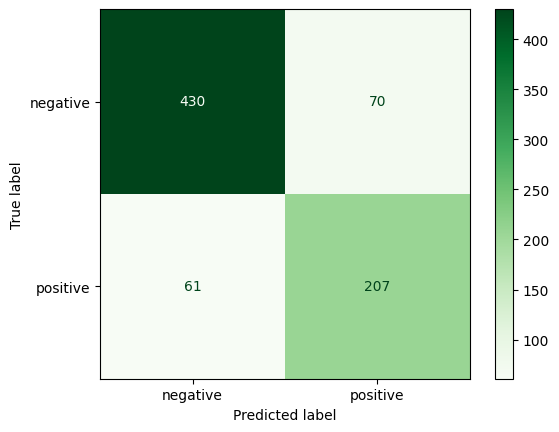

In [69]:
from sklearn.model_selection import cross_val_predict

tree = DecisionTreeClassifier(max_depth=12, random_state=42)
y_pred = cross_val_predict(tree, X, y, cv=4)
cm = confusion_matrix(y, y_pred)

labels = ['negative', 'positive']
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cm_display.plot(cmap=plt.cm.Greens)

<b>6) Random Forest</b>

In [80]:
from sklearn.ensemble import RandomForestClassifier

mdl = RandomForestClassifier(
            criterion='gini',
            max_features=0.8,
            bootstrap=True,
            max_samples=0.8,
            random_state=42
        ).fit(X_train, y_train)

params_grid = {
    'n_estimators': [50, 80, 100, 200],
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


clf = GridSearchCV(
    estimator=mdl,
    param_grid=params_grid,
    scoring='f1',
    cv=4
).fit(X, y)

In [82]:
print("Best parameters: ", clf.best_params_)
print("Best F1 score: ", clf.best_score_)

Best parameters:  {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 score:  0.8429585668940366


In [83]:
def cv_random_forest(X, y):
    precisions, recalls, f1s, aucs = [], [], [], []
    for train_idx, test_idx in kf.split(X):
        X_train, y_train = X.loc[train_idx], y[train_idx]
        X_test, y_test = X.loc[test_idx], y[test_idx]
        
        mdl = RandomForestClassifier(
            n_estimators = 200,
            criterion='gini',
            max_depth=5,
            min_samples_split=2,
            min_samples_leaf=1,
            max_features=0.8,
            bootstrap=True,
            max_samples=0.8,
            random_state=42
        ).fit(X_train, y_train)
        
        
        y_pred = mdl.predict(X_test)
        
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        aucs.append(roc_auc_score(y_test, y_pred))
        
    avg_precision = sum(precisions)/kf.n_splits
    avg_recall = sum(recalls)/kf.n_splits
    avg_f1 = sum(f1s)/kf.n_splits
    avg_auc = sum(aucs)/kf.n_splits
        
    return [avg_precision, avg_recall, avg_f1, avg_auc]

In [84]:
results = cv_random_forest(X, y)

print(f'Average Precision: {results[0]}')
print(f'Average Recall: {results[1]}')
print(f'Average F1-score: {results[2]}')
print(f'Average AUC: {results[3]}')

Average Precision: 0.8366138763197587
Average Recall: 0.842599192207175
Average F1-score: 0.838626528971373
Average AUC: 0.8761885056797062


In [85]:
model_results['RandomForestClassifier'] = {'Precision': results[0],
                                            'Recall': results[1],
                                            'F1 score': results[2],
                                            'AUC': results[3]
                                            }

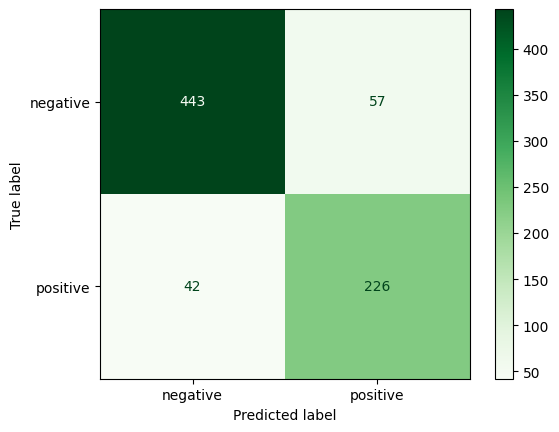

In [86]:
from sklearn.model_selection import cross_val_predict

rfc = RandomForestClassifier(
            n_estimators = 80,
            criterion='gini',
            max_depth=3,
            min_samples_split=10,
            min_samples_leaf=5,
            max_features=0.8,
            bootstrap=True,
            max_samples=0.8,
            random_state=42
        )
y_pred = cross_val_predict(rfc, X, y, cv=4)
cm = confusion_matrix(y, y_pred)

labels = ['negative', 'positive']
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
cm_display.plot(cmap=plt.cm.Greens)

In [87]:
results_df = pd.DataFrame.from_dict(model_results, orient='index')
results_df

,Precision,Recall,F1 score,AUC
LR with thr=0.3,0.686959,0.584224,0.629130,0.720059
SVC,0.786976,0.843074,0.814012,0.860538
KMeans,0.639098,0.634328,0.636704,0.721164
NBC,0.668765,0.629128,0.646508,0.730439
DecisionTreeClassifier,0.783732,0.787776,0.784913,0.835690
RandomForestClassifier,0.836614,0.842599,0.838627,0.876189


Отже, із тих моделей, що були побудовані для датасету `diabetes.csv`, <b>Support Vector Machine (SVC)</b> та <b>Random Forest Classifier</b> впоралися найкраще із завданням бінарної класифікації (передбачення діабету).